# Part 0 // Introduction

## Blight in Detroit

In this project, done as a Capstone project for the 'Data Science at Scale' specialization by Bill Howe from the University of Washington, we are tackling the topic of blight in the lifecycle of a city. Since the demise of its automotive industry, Detroit has seen its population cut in half, its crime rate flirt with the [top of the US charts](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_crime_rate), and its urban decay reach gruesome proportions. So much so that the city [filed bankrupcy](https://en.wikipedia.org/wiki/Detroit_bankruptcy) in 2013. Since then, its officials have put blight on their top priority list, as they understand blight to be a key point in a vicious cycle. Their hopes are that by being able to predict the demolition of buildings far enough in advance, incentives can be set in place for people to maintain the buildings.

The subject is rather fascinating and there is a lot to be said about the ethics of data science in the political arena, especially connected to the matter of blight, as it is easy to see that those with lesser means could find a model of blight prevention not carefully thought through heighten systemic oppression policies that may already be in place.

Since its bankrupcy, the City of Detroit has received a grant to create an [open data platform](https://data.detroitmi.gov/) where its data on crime, finance, education, health, etc... are publicly accessible. Thanks to it we have access to the following data, which will help us in later works to help predict blight:
- Blight Violation incident from the city of Detroit
- Criminal Incidents from the Police Dept. of Detroit
- 311 call history from the non-emergency call center of the city of Detroit
- Demolition Permits issued by the city of Detroit


## Importing the data

We will at first focus on the Blight Violation records, as we expect it to have lots of valuable features for our model. Let's start by loading the needed libraries

In [3]:
# DATA SERIALIZATION
import pickle

# DATA MANIPULATION
import numpy as np # linear algebra
import random as rd # generating random numbers
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt# manipulating date formats
from operator import add # elementwise addition


# DATA VIZUALIZATION
import matplotlib.pyplot as plt # basic plotting
import seaborn # for prettier plots


# GEOGRAPHIC DATA
import geopandas as gpd
import geocoder
import folium # plotting data on interactive maps
from folium.plugins import MarkerCluster # creating clustring layer for folium
import time #to respect Google's API per second request limits

# NATURAL LANGUAGE PROCESSING
import nltk

# WEB SCRAPING
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import requests

# UNSUPERVISED LEARNING
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC

As for all large collection of data, we can expect a lot of work to be required before having clean and polished data, ready for exploratory analysis or feature engineering. Let's import the violation file and prepare it for analysis:

In [13]:
# READING THE CSV FILE
def open_file(path):
    
    with open(path,'rb') as File:
        #IMPORTING EVERYTHING AS STRING FOR CLEAN-UP PURPOSES
        Table=pd.read_csv(File,dtype=np.str,encoding = 'ISO-8859-1')

    # REMOVING UNECESSARY DATA
    for col in Table:
        if (len(Table[col].dropna().unique())==1):
            Table.drop(col,axis=1,inplace=True)
            
    # GIVING THE NUMBER OF DUPLICATED INDEX ENTRIES AND OTHER INFO
    print('There are {} duplicated ticketIDs entries.'.format(Table.duplicated('TicketID').sum()))
    print('Here is the rest of the table summary:\n')
    print(Table.info(memory_usage='deep'))

    return Table

def format_violations(Table):
    
    Table=(Table.pipe(preformat_DT)
           .pipe(extract_coord,'ViolationAddress',['ViolAddStreetNumber','ViolAddStreetName','ViolLatitude','ViolLongitude'])
           .pipe(cast_types)
           .pipe(all_upper)
          )
    
    
    if (Table['ViolAddStreetNumber']==Table['ViolationStreetNumber']).all() and all([x[0] in x[1] for x in zip(Table['ViolAddStreetName'],Table['ViolationStreetName'])]):
        Table.drop(['ViolAddStreetNumber','ViolAddStreetName','ViolationAddress'],axis=1,inplace=True)
        Table=clean_street_type(Table,'ViolationStreetName')
        print('Violation addresses are coherent')
    else:
        print('There are {} differences between the violation street number field and the violation address field\'s street number'.format(np.sum(Table['ViolAddStreetNumber']!=Table['ViolationStreetNumber'])))
        print('There are {} differences in the street names between the ViolationStreetName field and the ViolationAddress field'.format(np.sum([x[0] in x[1] for x in zip(Table['ViolAddStreetName'],Table['ViolationStreetName'])])))
        print('Street types not cleaned from street name field')
    
    # FILLING UP MISSING NAME WITH EMPTY NAME
    Table['ViolName'].fillna('',inplace=True)
    
    # SETTING THE COUNTRY CORRECTLY
    Violations.loc[Violations.Country.isnull()&~Violations.NonUsAddressCode.isnull(),'Country']=Violations.loc[Violations.Country.isnull()&~Violations.NonUsAddressCode.isnull(),'NonUsAddressCode'].str.extract(r'(\w+)$',expand=False)
    Violations.Country.fillna('US',inplace=True)

    Table.drop_duplicates()
    return(Table)

def cast_types(Original):
    
    #______________________________________________
    # DEFINING TYPES OF VARIABLES
    #----------------------------------------------
    # pd.DataFrame ->            -> pd.DataFrame 
    #/////////////////////////////////////////////
    
    Table=Original.copy()
    return Table.assign(TicketID= lambda x: x.TicketID.astype(np.float32),
                        ViolationStreetNumber= lambda x: x.ViolationStreetNumber.astype(np.float32).abs(),
                        ViolAddStreetNumber= lambda x: x.ViolAddStreetNumber.astype(np.float32),
                        LateFee= lambda x: x.LateFee.str.replace(r'\$(\d+)(?=.).*','\g<1>').astype(np.float16),
                        FineAmt= lambda x: x.FineAmt.str.replace(r'\$(\d+)(?=.).*','\g<1>').astype(np.float16),
                        CleanUpCost= lambda x: x.CleanUpCost.str.replace(r'\$(\d+)(?=.).*','\g<1>').astype(np.float16),
                        JudgmentAmt= lambda x: x.JudgmentAmt.str.replace(r'\$(\d+)(?=.).*','\g<1>').astype(np.float16),
                        ViolLatitude=lambda x: x.ViolLatitude.astype(np.float32),
                        ViolLongitude=lambda x: x.ViolLongitude.astype(np.float32),
                        TicketIssuedDT= lambda x: pd.to_datetime(x['TicketIssuedDT']),
                        HearingDT= lambda x: pd.to_datetime(x['HearingDT']),
                        TicketIssuedTime= lambda x: pd.to_datetime(x['TicketIssuedTime']) #,
                        #CourtTime= lambda x: pd.to_datetime(x['CourtTime'])
                       )


def preformat_DT(Original):
    
    #______________________________________________
    #   FORMATTING ALL THE DATES TO DD/MM/YYYY
    #----------------------------------------------
    # pd.DataFrame ->            -> pd.DataFrame 
    #/////////////////////////////////////////////
    
    Table=Original.copy()
    Table.TicketIssuedDT= (Table.TicketIssuedDT.str.replace(r'.*(?<=01/01/)(?P<date>\d{5}).*',lambda m:(dt.datetime(1900,1,1)+dt.timedelta(int(m.group('date')))).strftime('%d/%m/%Y'))
                           .str.replace(r'(\d{2}/\d{2}/\d{4}).*',r'\g<1>'))
    Table.HearingDT= (Table.HearingDT.str.replace(r'.*(?<=01/01/)(?P<date>\d{5}).*',lambda m:(dt.datetime(1900,1,1)+dt.timedelta(int(m.group('date')))).strftime('%d/%m/%Y')).str.replace(r'(\d{2}/\d{2}/\d{4}).*',r'\g<1>'))
    return Table


def all_upper(Original):
    
    #______________________________________________
    # STRIPPING TRAILING SPACES AND MULTIPLE SPACES
    #----------------------------------------------
    # pd.DataFrame ->            -> pd.DataFrame 
    #/////////////////////////////////////////////
    
    Table=Original.copy()
    Table.loc[:,Table.dtypes=='object']=(Table.loc[:,Table.dtypes=='object']
                                         .apply(lambda x: x.str.upper())
                                         .apply(lambda x: x.str.strip())
                                         .apply(lambda x: x.str.replace(r'\s+',' ')))
    return Table


def extract_coord(Original,From,To=['Number','Street','Latitude','Longitude']):
    #______________________________________________
    # EXTRACTING DATA FROM ADDRESS FIELDS
    #----------------------------------------------
    # pd.DataFrame ->            -> pd.DataFrame
    # added col = Number, Street, Latitude,
    #             Longitude
    #/////////////////////////////////////////////

    Table=Original.copy()
    Table[To]= (Table[From].str.strip()
                .str.upper()
                .str.replace(r'\s+',' ')
                .str.extractall(r'(?P<Number>\d*) (?P<Street>.+)(?= DETROIT).*(?<=\()(?P<Latitude>[-\d.]*)\, (?P<Longitude>[-\d.]*)')
                .reset_index(level=1,drop=True))
    return Table

def get_street_abbrev_dic():
    
    #______________________________________________
    # RETRIEVING THE DICTIONARY OF ABBREVIATIONS 
    # FOR STREETS FROM THE USPS WEBSITE
    #----------------------------------------------
    #  NULL ->              -> dict 
    #/////////////////////////////////////////////
    
    
    try:
        with open('.\Pickles\Street_types_dict.p') as File:
            dictionary=pickle.load(File)
    except:
        # STARTING A REQUEST SESSION
        s = requests.Session()

        # SETTING THE USER AGENT TO AVOID A REDIRECT LOOP
        s.headers['User-Agent'] = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/34.0.1847.131 Safari/537.36'

        # RETRIEVING THE PAGE
        r=s.get('https://pe.usps.com/text/pub28/28apc_002.htm')
        Whole=Selector(text=r.text).xpath('//table[@id="ep533076"]//tr[count(td)=3]//td[2]//a/text()|//table[@id="ep533076"]//tr[count(td)=1]//td//a/text()').extract()[4:]
        Abbrev=pd.Series(Selector(text=r.text).xpath('//table[@id="ep533076"]//td[3]//a/text()').extract()[4:])
        Repeats=[int(Selector(text=row).xpath('//td/@rowspan').extract()[0]) if len(Selector(text=row).xpath('//td/@rowspan').extract()) != 0 else 1 for row in Selector(text=r.text).xpath('//table[@id="ep533076"]//tr[count(td)=3]').extract()[1:]]
        S=Abbrev.values.repeat(Repeats)
        dictionary={whole:S[i] for i,whole in enumerate(Whole)}
        pickle.dump(dictionary,open('.\Pickles\Street_types_dict.p','wb'))
    return dictionary


def get_street_type(addr):
    
    #______________________________________________
    # GETTING THE STREET TYPE FROM THE ADDRESS
    #----------------------------------------------
    # string ->                     -> string
    # Series ->                     -> series
    #/////////////////////////////////////////////
    
    dic=get_street_abbrev_dic()
    
    if isinstance(addr,str):
        x=addr.split()
        if len(x)>1:
            result=dic.get(x[-1],None)
        else:
            result=None
    elif isinstance(addr,(list,pd.Series,np.ndarray)):
        if(pd.isnull(addr).mean()>0):
            raise ValueError('The list of streets contains NAN')
        result=[dic.get(x[-1],None) if len(x)>1 else None for x in addr.str.split()]
    else:
        raise ValueError('Address field of unknown type.')
    return result
    
def clean_street_type(data,addr_field=None):
    
    #______________________________________________
    # RIDDING THE ADDRESS OF THE STREET TYPE
    #----------------------------------------------
    # string ->                     -> string
    # Series ->                     -> Series
    # DataFrame->       ->DataFrame + Type col   
    #/////////////////////////////////////////////
    
    if isinstance(data,str):
        result=get_street_type(data)
    elif isinstance(data,(list,pd.Series,np.ndarray)):
        result=get_street_type(data)
    elif isinstance(data,pd.DataFrame):
        result=data.copy()
        try:
            new_field=addr_field+'_type'
        except:
            raise ValueError('No address column specified')
        kwargs={new_field: lambda x: get_street_type(x[addr_field])}
        kwargs2={addr_field: lambda x: x[addr_field].mask(~pd.isnull(x[new_field]), x[addr_field].str.replace(r'\s\w+$',''))}
        result=(result.assign(**kwargs)
               .assign(**kwargs2))
    else:
        raise ValueError('Input of unknown type. Please givea string or a dataframe.')
    return result

Violations.drop_duplicates('TicketID',inplace=True)

In [14]:
try:
    Violations=pd.read_pickle('.\Pickles\Violations.p')
except:
    Violations=open_file('detroit-blight-violations.csv')
    Violations=format_violations(Violations)
    Violations.to_pickle('.\Pickles\Violations.p')

There are 6237 duplicated ticketIDs entries.
Here is the rest of the table summary:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307804 entries, 0 to 307803
Data columns (total 28 columns):
TicketID                 307804 non-null object
TicketNumber             307804 non-null object
AgencyName               307804 non-null object
ViolName                 307802 non-null object
ViolationStreetNumber    307804 non-null object
ViolationStreetName      307804 non-null object
MailingStreetNumber      307802 non-null object
MailingStreetName        307804 non-null object
MailingCity              307382 non-null object
MailingState             306916 non-null object
MailingZipCode           307377 non-null object
NonUsAddressCode         425 non-null object
Country                  18484 non-null object
TicketIssuedDT           307804 non-null object
TicketIssuedTime         307804 non-null object
HearingDT                307804 non-null object
CourtTime                307804 non-null

First and foremost, we found 6237 tickets that are duplicated in the dataset. That is to be investigated first after clean-up and formatting. We can also see some particularities appearing. For example, though about 2000 entries are missing the 'MailingAddress' field, none are missing the 'MailingStreetName' and only two are missing the 'MailingStreetNumber' field. It shows that these latter features were not extracted from the former by an algorithm.
We note that two also lack a violator name and there is one more entry with a Judgment Amount than with a Fine Amount. We will have to investigate these issues as well.

The functions above cleaned the fields of unnecessary spaces, checked the coherence of the address fields, extracted the type of way, using the UPSP's website's dictionary of abbreviations, extracted the GPS coordinates from the address field and set times and dates to a temporal type. Let us check the summary of our new dataframe:

In [12]:
Violations.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307804 entries, 0 to 307803
Data columns (total 30 columns):
TicketID                    307804 non-null float32
TicketNumber                307804 non-null object
AgencyName                  307804 non-null object
ViolName                    307804 non-null object
ViolationStreetNumber       307804 non-null float32
ViolationStreetName         307804 non-null object
MailingStreetNumber         307802 non-null object
MailingStreetName           307804 non-null object
MailingCity                 307382 non-null object
MailingState                306916 non-null object
MailingZipCode              307377 non-null object
NonUsAddressCode            425 non-null object
Country                     18484 non-null object
TicketIssuedDT              307804 non-null datetime64[ns]
TicketIssuedTime            307804 non-null datetime64[ns]
HearingDT                   307804 non-null datetime64[ns]
CourtTime                   307804 non-null object


By doing the cleanup work, we lost about 4000 entries already, but some duplicates remain. We wrote a function to check the fields where they each differ. A lot of these tickets appear twice, once With the amount not paid and once with the payment in full. But for the sake of simplicity, let us drop them, keeping only the first of the duplicates.

In [ ]:
def check_duplicates(data):
    Doubles=data.set_index('TicketID').copy()
    D=Doubles.index.get_duplicates()
    for item in D:
        rows=[]
        for row in Doubles:
            Y=Doubles.loc[item,:]
            if len(Y[row].unique())==1:
                    rows.append(row)
            else:
                if (row=='PaymentStatus') and ('PAID IN FULL' in Y[row].unique()):
                    Doubles.loc[item,row]='PAID IN FULL'
                elif (row=='ViolationStreetType') and (Y[row].nunique()==1):
                    Doubles.loc[item,row]=Y[row].dropna().unique()[0]
    return Doubles.drop_duplicates().reset_index()

# Part 1 // Defining Buildings

We want to create a file with all buildings in the city, so as to mark them individually as warranting care or not (in other word assessing their probability of being demolished within a certain number of years). As it turns out the city of Detroit has made publicly acessible the [GeoData of its parcels](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf/data) in GeoJSON and Shapefile format, which we can use.

We will eventually use these in our analysis, but a quick glance on the map provided on the page already shows that most buildings correspond to a unique parcel, which is good news. Parcels without a building are plentiful and can be kept in our file as theoretically they can be sold and become home to a building. A few parcels host multiple buildings, and at first glance it seems that these mainly correspond to hospitals, schools and public offices rather unlikely to be subject to blight. (or if they do, the data science portion of the local government will not have been a priority for a while)

## Working with the bligh violation tickets geographical data

In the blight violation data, there are two main geographical fields, each of which contain GPS coordinates and addresses:
- the violation address
- the mailing address of the owner

Of course, these have been entered by humans and will most likely contain mistakes, typos or other inconveniences for analysis. Some tidying up will be needed.

Ideally, each building corresponds uniquely to a violation address. It is a little naive to think that it would readily be the case but we can definitely check. It seems that more granular features have already been extracted from these fields, but we don't know yet how it was done, whether the human doing the data entry typed them in a different field, increasing the probability of having typos or if an algorithm did it, increasing the chances of irregular cases being handled poorly. 

Let's explore this data.

### Builidngs = addresses ?

We first build a table showing how many tickets were issues per address. We can give a glance at it and see if we already see some irregularities or if this approach seems promising.

In [7]:
def define_locations():
    # ADDING STREET NAMES AND NUMBERS FROM THE TABLE
    X= Violations.loc[:,['TicketID','TicketNumber','ViolName','ViolationStreetNumber','ViolationStreetName','ViolLatitude','ViolLongitude']].copy()
    X['Coord']=[[X.loc[x,'ViolLatitude'],X.loc[x,'ViolLongitude']] for x in X.index]
    return X

Locations=define_locations().dropna()

# COMPUTING THE NUMBER OF INFRACTIONS BY UNIQUE STREET NAME AND NUMBER
Locations.groupby(['ViolationStreetName','ViolationStreetNumber']).size()

ViolationStreetName  ViolationStreetNumber
10TH                 0.0                      71
                     1.0                      15
                     2.0                       2
                     5.0                       1
                     11.0                      9
                     12.0                      2
                     55.0                      1
                     111.0                     3
                     112.0                     1
                     123.0                     1
                     456.0                     1
                     555.0                     2
                     711.0                     5
                     1000.0                    2
                     1110.0                    1
                     1111.0                    8
                     1211.0                    1
                     1234.0                    1
                     1709.0                    1
                     1921.

We can already see some erroneous data showing up. At first glance we have:
- **Fake street numbers** : Both 10th Street and Zender Street have the most infractions lacated at number 0. A little research or knowledge about the US street numbering system tells us that very few buildings have such street number. Moreover the fact that most of the infractions are located there indicates that 0 is most likely a placeholder for some human shortcoming. From the top of my head I could imagine:
    - The person writing the ticket thought 'I don't know' or 'I don't want to bother finding, as long as he pays the fine' and placing a 0 there.
    - The number simply being omitted on the ticket and the person entering the data in the system being forced to enter a number to validate the submission.
    - The algorithm extracting the number from the full address using 0 as NA value.

- **Fake street numbers (bis)** We also note the presense of patterns in the numbers shown for 10th Street, for example lots single digit repetitions or sequences of digits, show that there is indeed something strange here that is again coming from some human shortcoming. This is especially clear as few other addresses start with 1 in this street. We should investigate the full address to see if these mistakes were there before feature extraction or come from it.    

Let's investigate these '0 10th ST' violations:

In [8]:
def AddressReport(street,number):
    if (street!='ALL'):
        Report=Locations.loc[(Locations['ViolationStreetName'] == street.upper()) & (Locations['ViolationStreetNumber']==number),:]
    else:
        Report=Locations.loc[Locations['ViolationStreetNumber']==number,:]
    print('These are {} GPS location(s) associated to this address'.format(len(Report.groupby(['ViolLatitude','ViolLongitude']).size())))
    return Report

AddressReport('10TH',0).head(40)

These are 2 GPS location(s) associated to this address


,TicketID,TicketNumber,ViolName,ViolationStreetNumber,ViolationStreetName,ViolLatitude,ViolLongitude,Coord
740,24928.0,05000793DAH,"XXX, XXX XXX",0.0,10TH,42.369785,-83.216324,"[42.3698, -83.2163]"
45486,71887.0,06006958DAH,"0000000000000000000000, 000000000000000000000",0.0,10TH,42.369785,-83.216324,"[42.3698, -83.2163]"
136844,157969.0,08015338DAH,"VOID, VOID",0.0,10TH,42.369785,-83.216324,"[42.3698, -83.2163]"
140283,168151.0,08018850DAH,"0000000000000, 00000000000000",0.0,10TH,42.369785,-83.216324,"[42.3698, -83.2163]"
167326,197008.0,08046575DAH,"VOID, VOID",0.0,10TH,42.369785,-83.216324,"[42.3698, -83.2163]"
167352,195261.0,08046601DAH,"VOID, VOID",0.0,10TH,42.369785,-83.216324,"[42.3698, -83.2163]"
206374,256880.0,10000259DAH,"VOID, VOID",0.0,10TH,42.369785,-83.216324,"[42.3698, -83.2163]"
206378,256893.0,10000263DAH,"VOLD, VOLD",0.0,10TH,42.369785,-83.216324,"[42.3698, -83.2163]"
206380,256900.0,10000265DAH,"VOLD, VOLD",0.0,10TH,42.369785,-83.216324,"[42.3698, -83.2163]"
230176,265028.0,10030084DAH,"VOID, VOID VOID",0.0,10TH,42.369785,-83.216324,"[42.3698, -83.2163]"


It is now painfully clear that we are dealing with errors, and a closer look at the main table wouls show that out of the 71 entries, only one makes sense remotely, as it has a sensible mailing address. It seems that it could take a while to clean up the file enough for this approach to be fruitful, but we can remove some cases without doing too much harm. Note that some citizens of Detroit have 'void' in their names, so we must be careful. Also, it should be noted that the Violator's name being incorrectly entered does not imply the address is incorrect.

In [9]:
Excluded_num=[0,12345,123456,1234567,12345678,111111,1111111,11111111,111111111,99999,999999,9999999,99999999,999999999]
Excluded_Names=['DOE, JOHN','XXXX, XXXX','XXX, XXX XXX','XXXX, XXXX X','VOID, VOID','ABCDEF']
Locations=Locations[[x not in Excluded_num for x in Locations.ViolationStreetNumber]]
Locations=Locations[[x not in Excluded_Names for x in Locations.ViolName]];

    
### Buildings = GPS locations?

  So far we have two dataframes:
  - Violations: All the blight related tickets of Detroit
  - Locations: A table with all long/lat/addresses combinations present in Violations
  
We should now proceed with the second hypothesis: each GPS location represents a building. Let's check it immediately by grouping Locations by GPS locations and plotting it:

There are 654 GPS locations with more than 1 address
Here is a graph showing the distribution:


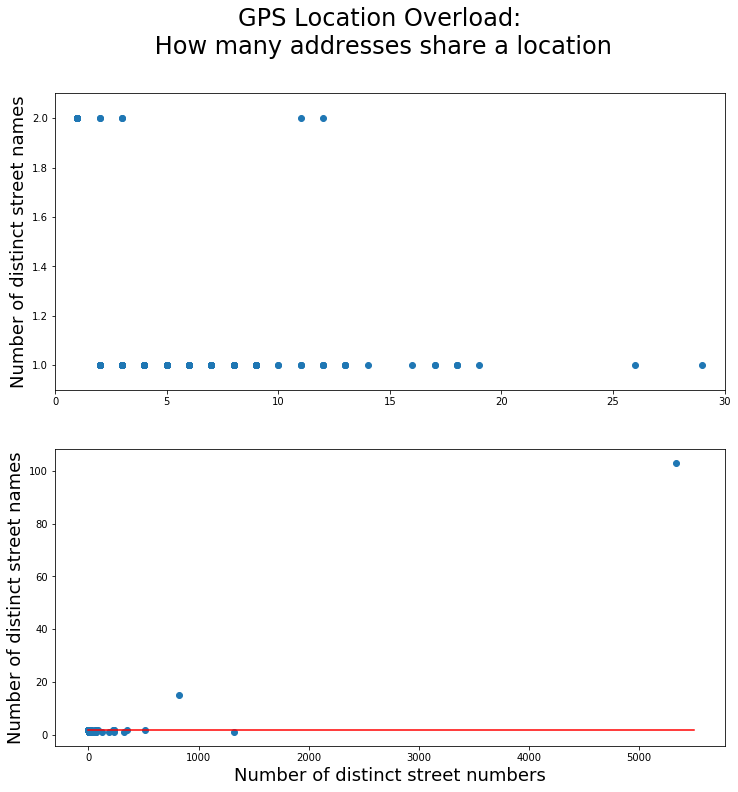

In [10]:
def plot_GPS_count(Origin):
    
    # MAKING A TABLE COUNTING THE UNIQUE ADDRESSES PER GPS LOCATIONS
    X=Origin.groupby(['ViolLongitude','ViolLatitude']).agg({'ViolationStreetName' : 'nunique','ViolationStreetNumber': 'nunique'}).reset_index().rename(columns={'ViolationStreetName' : 'DistinctStreets','ViolationStreetNumber': 'DistinctNumbers'})
    # FILTERING OUT THE REGULAR CASES
    X=X[(X.DistinctStreets>1)|(X.DistinctNumbers>1)]

    # DISPLAYING INFORMATION
    print('There are {} GPS locations with more than 1 address'.format(len(X)))
    print('Here is a graph showing the distribution:')

    plt.figure(figsize=(12,12))
    plt.subplot(2,1,1)
    plt.scatter(X.DistinctNumbers,X.DistinctStreets)
    plt.xlim(0,30)
    plt.ylim(0.9,2.1)
    plt.ylabel('Number of distinct street names',fontsize=18)
    plt.subplot(2,1,2)
    plt.plot([0,5500],[2,2],c='red')
    plt.scatter(X.DistinctNumbers,X.DistinctStreets)
    plt.xlabel('Number of distinct street numbers',fontsize=18)
    plt.ylabel('Number of distinct street names',fontsize=18)
    plt.suptitle('GPS Location Overload:\n How many addresses share a location',fontsize=24)
    plt.show()
    return X

GPS_Count=plot_GPS_count(Locations)

The red line represents 2 distinct street names.

We only plotted the 614 locations with more than 1 address associated to them. We could forecast small deviations from typos we haven't fixed yet, but two locations have a number of different street names that cannot be accounted for by language subtleties. One has almost 20 and another over a hundred. 
Aslo, one location has up to 1000 different numbers for 1 or 2 street names.

Below is a table showing a sample of streets with possible types. The first group have two street names, 'ROUGE' and 'ROGGE', both existing streets, but with a GPS locations that corresponds to neither of them. Let's plot them on a map.

In [11]:
def get_typos(Table):
    X=Table.groupby(['ViolLatitude','ViolLongitude']).agg({'ViolationStreetName' : 'nunique','ViolationStreetNumber': 'nunique'}).rename(columns={'ViolationStreetName' : 'DistinctStreets','ViolationStreetNumber': 'DistinctNumbers'}).copy()
    # FILTERING OUT THE REGULAR CASES
    return X[(X.DistinctStreets==2)]


Locations.set_index(['ViolLatitude','ViolLongitude']).loc[get_typos(Locations).index,['ViolName','ViolationStreetNumber','ViolationStreetName']].drop_duplicates()

ViolName  \
ViolLatitude ViolLongitude                                              
42.293606    -83.151108                              BRADFORD, ANDREW   
             -83.151108                               SMITH, ANTWANDA   
             -83.151108                             HAYES, FRANKLIN D   
42.297764    -83.110481                                RAMIREZ, MARIO   
             -83.110481        MORTGAGE ASSOCIATION, FEDERAL NATIONAL   
42.297817    -83.110344                             JONES, MICHAEL A.   
             -83.110344                              JONES, MICHAEL A   
             -83.110344                                  HRYCYK, PAUL   
             -83.110344                      CORNER POCKET LOUNGE , .   
42.298145    -83.109528                              EVARISTO, JURADO   
             -83.109528                              EVARISTO, JURADO   
42.305019    -83.113258                           ALLEY LTD, TRAPPERS   
             -83.113258                              NEGRI,JR, GEORGE   
             -83.113258                                APT., CITYSIDE   
             -83.113258                             GONZALES, MAUREEN   
             -83.113258     C/O COLLIERS INTERNATIONAL, COMERICA BANK   
             -83.113258                                 HOTEL, SHELBY   
             -83.113258                              CITYSIDE APT., *   
             -83.113258                              CITYSIDE APT., *   
             -83.113258                                APTS, CITYSIDE   
             -83.113258         ATTN: JERRY BERDICK, RIVER PARK PLACE   
             -83.113258               JERRY BERDICK, RIVER PARK PLACE   
             -83.113258                          & POTESTIVO, ABRAHAM   
             -83.113258                                   LOFT, F. P.   
             -83.113258                  MANAGEMENT SER., INDEPENDENT   
             -83.113258                     COOPERATIVE, RALPH BUNCHE   
             -83.113258                     COOPERATIVE, RALPH BUNCHE   
             -83.113258                         SPORTS CITY CENTER, *   
             -83.113258                          LOFTS INC, LAFAYETTE   
             -83.113258                     COOPERATIVE, RALPH BUNCHE   
...                                                               ...   
42.426426    -83.211441                 AMERCO REAL ESTATE COMPANY, .   
             -83.211441                       WASTE DISPOSAL SERV., .   
             -83.211441                    AMERCO REAL ESTATE COMPANY   
             -83.211441                         FREDERICK ENTERPRISES   
             -83.211441                           W. Y. INVESTMENT CO   
             -83.211441                                POINT ONE, INC   
             -83.211441                                  FRANK BLYTHE   
             -83.211441                                PERRY, SARAH J   
42.426647    -83.231812                MANAGEMENT LLC, NATIONAL ASSET   
             -83.231812                           MANAGMENT, NATIONAL   
             -83.231812               STONECREST INCOME & INVESTMENT,   
42.426662    -83.227791                               KING, RASCHON D   
             -83.227791       COMMUNITY DEVELOPMENT CORP, NEW SEASONS   
             -83.227623                       WELBORNE, DAMIAN GERARD   
             -83.227623                   RAYMOND MELBORNE, ESTATE OF   
             -83.227623                   RAYMOND WELBORNE, ESTATE OF   
             -83.227623                    MCCLAIN, RICHARD B & MAYCE   
             -83.227623                          WELBORNE, RAYMOND N.   
             -83.227623                      & MAYCE MCCLAIN, RICHARD   
             -83.227623                       &MAYCE MCCLAIN, RICHARD   
             -83.227623                 MCCLAIN, RICHARD B. AND MAYCE   
42.434200    -83.211884                               SALES, GERTRUDE   
             -83.211884                       

In [12]:
# CREATING A MAP
Duplicates_map=folium.Map(location=[42.3,-83.05],tiles='Stamen Toner',zoom_start=11)

# CREATING LAYERS FOR THE MAP
First_layer=folium.FeatureGroup(name='Distinct Numbers')
Second_layer=folium.FeatureGroup(name='Distinct Streets')

# DEFINING A FUNCTION TO FILL MAPS OR LAYERS WITH CIRCLE MARKERS
def add_location(x,r,obj,color='#3498DB',mult=1):
    #Using Circle vs CircleMarker changes the unit the radius is given in. meters for the former, pixels for the latter.
    if r>1:
        folium.Circle(location=x,radius=mult*r,color=color,fill=True).add_to(obj)

# ADDING MARKERS FOR THE IRREGULAR GPS LOCATIONS - BLUE FOR DISTINCT STREET NUMBERS AND RED FOR STREET NAMES
GPS_Count.apply(lambda x: add_location([x.ViolLatitude,x.ViolLongitude],x.DistinctNumbers,First_layer),axis=1)
GPS_Count.apply(lambda x: add_location([x.ViolLatitude,x.ViolLongitude],x.DistinctStreets,Second_layer,'#EC7063',10),axis=1)

# ADDING LAYERS AND LAYER CONTROL
First_layer.add_to(Duplicates_map)
Second_layer.add_to(Duplicates_map)
folium.LayerControl().add_to(Duplicates_map)
#Duplicated_map.save('GPS_issues.html')

# DISPLAYING THE MAP
Duplicates_map

A lot of points have a blue circle of radius and no a red circle, which in most cases means all the tickets on the street have been collected into a single GPS location, most likely provided by a database of some sort. The long horizontal line below the west 7Mile road is quite characteristic of this phenomenon. There are also some streets with a bunch of red dots, the most obvious being Fischer street, west of Gratiot Avenue. These are street whose names are easily misspelled. Note that the clean-up removed a lot them, those where an 'Avenue' or 'street' indicator that is not always present. 

There is also the HUMONGOUS circles at a location a few meters away from the SEMCOG, the Southeast Michigan Council of Governments. I believe that these tickets have had the location of the place they have been entered in the system put in place of the location where the violation was committed.

We define below a reverse geocoding tool so as to provide a proper location to these addresses.

In [19]:
def get_from_google(to_solve):
    #_______________________________________________
    # GETS REVERSE GEOLOCATION FROM GOOGLE MAP
    #-----------------------------------------------
    # [LAT,LONG] pair ->               -> geocoder
    # list of [LAT,LONG] pairs -> list of geocoders 
    #//////////////////////////////////////////////
    
    #LOADS THE GOOGLE API KEY
    try:
        GOOGLE_API_KEY
    except:
        GOOGLE_API_KEY = open('Googleapikey.txt','r').read()

    if isinstance(to_solve[0],list):
        # Max 50 requests per second, 2500 per day.
        google=[]
        start=dt.datetime.now()
        n=0
        for item in to_solve:
            n=n+1
            if ((dt.datetime.now()-start).seconds<1) and (n<50):
                google.append(geocoder.google(item, method='reverse',key=GOOGLE_API_KEY))
            else:
                time.sleep(2)
                n=0
                start=dt.datetime.now()
    else:
        google=geocoder.google(item, method='reverse',key=GOOGLE_API_KEY)
    return google


RESULTS=get_from_google([[GPS_Count.loc[x,'ViolLatitude'],GPS_Count.loc[x,'ViolLongitude']] for x in GPS_Count.index])

Note that for reasons of time, we will not do the work of replacing these locations, but I believe that it is important to clean these up as to not leave behing a significant portion of the distribution of tickets, as nothing ensures that the mistakes are randomly distributed on the city area. Let us use the convenient tool that Detroit made publicly available: the parcels data:

## Loading parcels

In [13]:
def load_parcels():
    
    Parcel_col={'parcelno':'object',
            'propno':'numeric',
            'propstr':'object',
            'status':'categorical',
            'saledate':'datetime',
            'taxstatus':'categorical',
            'resyrbuilt':'datetime',
            'cibyrbuilt':'datetime',
            'objectid_1': 'int',
            'isimproved':'bool',
            'geometry':'geometry'}
    try:
        Parcels=pd.read_pickle('.\Pickles\Parcels.p')
    except:
        with open('Parcel Map.geojson','rb') as File:
            Parcels=(gpd.read_file('Parcel Map.geojson')
                     .loc[:,list(Parcel_col.keys())]
                     .assign(propno= lambda x: pd.to_numeric(x['propno']),
                             status= lambda x: x.status.astype('category'),
                             saledate= lambda x: pd.to_datetime(x['saledate']),
                             taxstatus= lambda x: x.taxstatus.astype('category'),
                             objectid_1= lambda x: pd.to_numeric(x['objectid_1'],downcast='unsigned'),
                             isimproved= lambda x: x.isimproved.astype('bool'))
                     .pipe(clean_street_type,'propstr')
                     .set_index('parcelno')
                     )
        #note - resyrbuilt has dates with days out of range for the month
        # same - cibyrbuilt= lambda x: pd.to_datetime(x['cibyrbuilt'])
        Parcels.to_pickle('.\Pickles\Parcels.p')
    return Parcels

Parcels=load_parcels()

The Parcels being loaded, we chose for now to use street name and number to represent buildings, as it is the most reliable, as far as knowing that there is a structure there. Below we define a function returning the parcel of choice, given GPS coordinates and an optional address. We use Google reverse geocoder to fill the missing information:

In [ ]:
def get_building(Coord=None,StrNum=None,StrName=None):
    #_______________________________________________
    # GETS A BUILDING FROM OUR DATABASE
    # If address is given, it takes precedence over
    # GPS coordinates.
    #-----------------------------------------------
    # Comb. of [LAT,LONG] pair, streen name & #  ->
    #           -> building record 
    #//////////////////////////////////////////////

    if ((Coord is None) and (StrNum is None)) or ((Coord is None) and (StrName is None)):
        raise ValueError('Not enough information was given. Please provide two of the Street Name and Number or GPS coord.')
    
    try:
        Parcels
    except:
        print('Loading Parcel database, may take a while.')
        load_parcels()
        print('Parcel data loaded.')
        
    if (StrNum is None) or (StrName is None):
        try:
            location=get_from_google(Coord)
        except:
            raise ValueError('Location not valid. Check type.')
        if (StrNum is None):
            StrNum=location.housenumber
        if (StrName is None):
            StrName=clean_street_type(location.street.upper())

        # A CHECK MUST BE MADE SOMEWHERE TO SEE THE COHERENCE OF THE FINDINGS
        #elif StrName.upper()!=clean_street_type(location.street.upper()):
        #    raise ValueError('The GPS Location and street name don\'t match: {} instead of {}.'.format(StrName,geocoded_StrName))
             
    try:
        result=Parcels.groupby(['propstr','propno']).get_group((StrName,StrNum))
    except:
        print('Building address not in database, checking GPS coord.')
        # HERE WE MUST USE THE PARCEL POLYGONS TO FIND WHERE THE GPS LOCATIONS LAND US
        
    
    return result

For the sake of further cross checking the validity of our records, we wrote the beginning of an algorithm that would set a buffer around parcels, collect all parcels containing the location of a given incident, reduce the buffer until only one remains and then return the corresponding parcel.

The image below tests for two points in some random streets of Detroit.

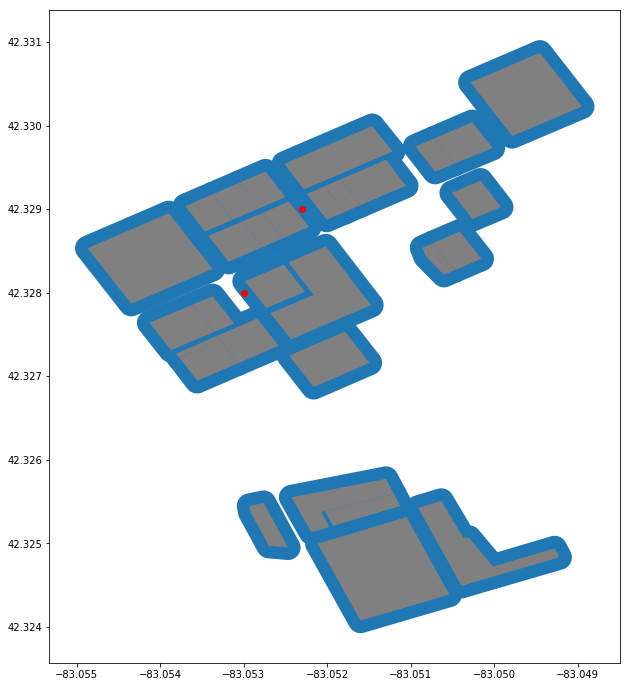

In [14]:
from shapely.geometry import Point, Polygon
p1=Point(-83.053,42.328)
p2=Point(-83.0523,42.329)
df = pd.DataFrame({'a': [11,22]})
fig, ax = plt.subplots(figsize=(12,12))
ax.set_aspect('equal')
gdf = gpd.GeoDataFrame(df, geometry = [p1,p2])
Parcels.reset_index().geometry[0:30].buffer(0.00015).plot(ax=ax)
Parcels.reset_index().geometry[0:30].plot(ax=ax,color='grey')
gdf.plot(ax=ax,color='red')
plt.show()

In [20]:
Parcels[Parcels.geometry.buffer(0.00015).contains(p1)]

,propno,propstr,status,saledate,taxstatus,resyrbuilt,cibyrbuilt,objectid_1,prevtstatu,isimproved,geometry,propstr_type
parcelno,,,,,,,,,,,,
04000097-100,541,FORT,Active,1992-04-01,TAXABLE,0,0,19067,TAXABLE,True,(POLYGON ((-83.05298508131509 42.3281374840999...,None
04000101.,601,FORT,Active,2014-07-07,TAXABLE,0,1912,19068,TAXABLE,True,(POLYGON ((-83.05337126751529 42.3279591131699...,None


# Part 2 // Prediction and Machine Learning


## IMPORTING DEMOLITION RECORDS

We are now ready to imprt the feature that we are looking towards predicting: forecoming demolitions. Let's read in the demolition permits table and clean it up with the tools we developed for the blight violation tickets.
Note that the parcel id and parcelno of both files are not equivalent, and short of finding the rule of conversion from one standard to the other, we are forced to abandon it as a unique id.


In [21]:
with open('detroit-demolition-permits.tsv','rb') as File:
    Demolitions=(pd.read_table(File)
                 .loc[:,['PARCEL_NO','SITE_ADDRESS','site_location']]
                 .pipe(extract_coord,'site_location',['StreetNumber','StreetName','Latitude','Longitude'])
                 .assign(StreetNumber=lambda x: x.SITE_ADDRESS.str.extract(r'^(\d+)',expand=False).str.strip(),
                         StreetName=lambda x: x.SITE_ADDRESS.str.extract(r'([A-Z ]+)',expand=False).str.strip())
                 .assign(StreetNumber=lambda x: pd.to_numeric(x['StreetNumber']))
                )
    
Demolitions.loc[pd.isnull(Demolitions.Latitude)]=(Demolitions.loc[pd.isnull(Demolitions.Latitude)]
                                                  .assign(Latitude= lambda x: x.site_location.str.extract(r'(?<=\()([.\d]+)',expand=False),
                                                           Longitude= lambda x: x.site_location.str.extract(r'([.\d]+)(?=\))',expand=False))
                                                 )
Demolitions['Demolitions']=Demolitions.groupby('PARCEL_NO')['StreetNumber'].transform('count')
Demolitions=(Demolitions
             .pipe(clean_street_type,addr_field='StreetName')
             .drop(['SITE_ADDRESS','site_location','StreetName_type'],axis=1)
             .drop_duplicates()
             .set_index('PARCEL_NO'))

In [22]:
Demolitions=Demolitions.reset_index().set_index(['StreetName','StreetNumber'])
Demolitions=Demolitions.loc[~Demolitions.index.duplicated(),:].sort_index()
Parcels=Parcels.reset_index().rename({'propstr':'StreetName','propno':'StreetNumber'},axis=1).set_index(['StreetName','StreetNumber'])
Parcels=Parcels.loc[~Parcels.index.duplicated(),:].sort_index()
Full_set=(pd.merge(Parcels,Demolitions.loc[:,['Demolitions']],how='left',left_index=True,right_index=True,validate='1:1')
          .assign(Demolitions= lambda x: x.Demolitions.fillna(0))
         )

Full_set

parcelno  status   saledate       taxstatus  \
StreetName StreetNumber                                                     
10TH       1921              08000447.  Active 1989-02-01         TAXABLE   
11TH       1916              08007238.  Active 1988-07-01         TAXABLE   
           1917          08007253.003L  Active 1985-11-01         TAXABLE   
           1923           08007253.002  Active 2006-06-23         TAXABLE   
           1932          08000474.002L  Active 1899-11-30         TAXABLE   
           2018              08007239.  Active 2014-06-13         TAXABLE   
           2030              08007240.  Active 2014-05-23         TAXABLE   
           2031           08007253.001  Active 1899-11-30         TAXABLE   
           2036              08007241.  Active 2015-05-18         TAXABLE   
           2037              08007252.  Active 1899-11-30         TAXABLE   
           2043              08007251.  Active 1899-11-30         TAXABLE   
           2046              08007242.  Active 2013-11-05         TAXABLE   
           2047              08007250.  Active 1899-11-30         TAXABLE   
           2051             08007246-9  Active 1899-11-30         TAXABLE   
           2052              08007243.  Active 2013-11-05         TAXABLE   
           2058             08007244-5  Active 1899-11-30         TAXABLE   
14TH       1000             10000074-6  Active 2012-02-28         TAXABLE   
           1206             10004841-3  Active 1899-11-30      CITY OWNED   
           1228              10004844.  Active 1899-11-30      CITY OWNED   
           1232              10004845.  Active 1899-11-30      CITY OWNED   
           1238              10004846.  Active 1899-11-30      CITY OWNED   
           1246              10004847.  Active 1899-11-30      CITY OWNED   
           1286            10004848-54  Active 2003-02-11         TAXABLE   
           1302              10004855.  Active 1899-11-30      CITY OWNED   
           1314             10004856-7  Active 2002-03-27         TAXABLE   
           1322              10004858.  Active 1899-11-30      CITY OWNED   
           1339            10005321-39  Active 1999-01-01         TAXABLE   
           1340              10004859.  Active 1899-11-30      CITY OWNED   
           1400              10004860.  Active 1899-11-30      CITY OWNED   
           1401              10005320.  Active 1999-01-01         TAXABLE   
...                                ...     ...        ...             ...   
YOUNG      15425             21015989.  Active 1899-11-30         TAXABLE   
           15435             21015990.  Active 1899-11-30         TAXABLE   
ZENDER     3627              13001736.  Active 2003-09-24  CITY LAND BANK   
           3628              13001735.  Active 1899-11-30  CITY LAND BANK   
           3638              13001734.  Active 1899-11-30  CITY LAND BANK   
           3639              13001737.  Active 1899-11-30         TAXABLE   
           3646              13001733.  Active 2004-08-10         TAXABLE   
           3647              13001738.  Active 1899-11-30         TAXABLE   
           3652              13001732.  Active 1899-11-30         TAXABLE   
           3653              13001739.  Active 1970-06-01         TAXABLE   
           3658              13001731.  Active 1899-11-30         TAXABLE   
           3659              13001740.  Active 1899-11-30  CITY LAND BANK   
           3663              13001741.  Active 1899-11-30         TAXABLE   
           3664              13001730.  Active 1899-11-30         TAXABLE   
           3670              13001729.  Active 1899-11-30         TAXABLE   
           3671              13001742.  Active 1899-11-30         TAXABLE   
           3676              13001728.  Active 2014-03-28         TAXABLE   
           3677              13001743.  Active 1899-11-30  CITY LAND BANK   
           3683              13001744.  Active 1899-11-30         TAXABLE   
           3684           

In [23]:
Full_set.reset_index().info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 378831 entries, 0 to 378830
Data columns (total 14 columns):
StreetName      378831 non-null object
StreetNumber    378831 non-null int64
parcelno        378831 non-null object
status          378831 non-null category
saledate        378831 non-null datetime64[ns]
taxstatus       378831 non-null category
resyrbuilt      378831 non-null object
cibyrbuilt      378831 non-null object
objectid_1      378831 non-null uint32
prevtstatu      378831 non-null object
isimproved      378831 non-null bool
geometry        378831 non-null object
propstr_type    869 non-null object
Demolitions     378831 non-null float64
dtypes: bool(1), category(2), datetime64[ns](1), float64(1), int64(1), object(7), uint32(1)
memory usage: 31.4+ MB
